## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/codes.txt'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/valid.txt'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/images/Seq05VD_f03780.png'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/images/Seq05VD_f02430.png'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/images/0016E5_08081.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/Seq05VD_f03330_P.png'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/0016E5_08149_P.png'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/0001TP_010260_P.png')]

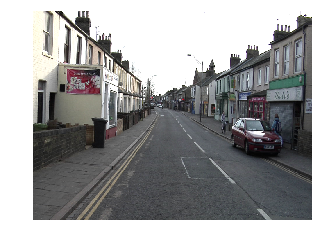

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

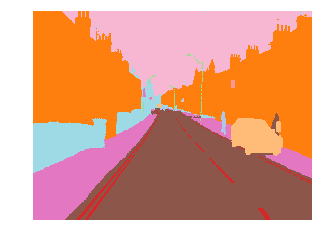

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [12]:
size = src_size//2
# size = (2500, 650)
bs=8

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

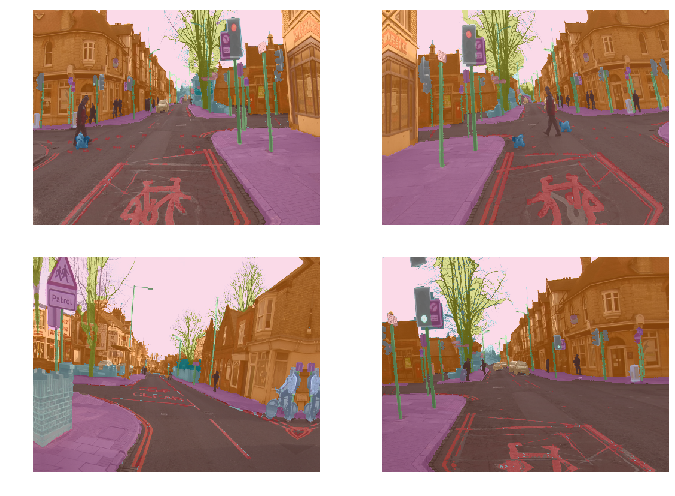

In [15]:
data.show_batch(2, figsize=(10,7))

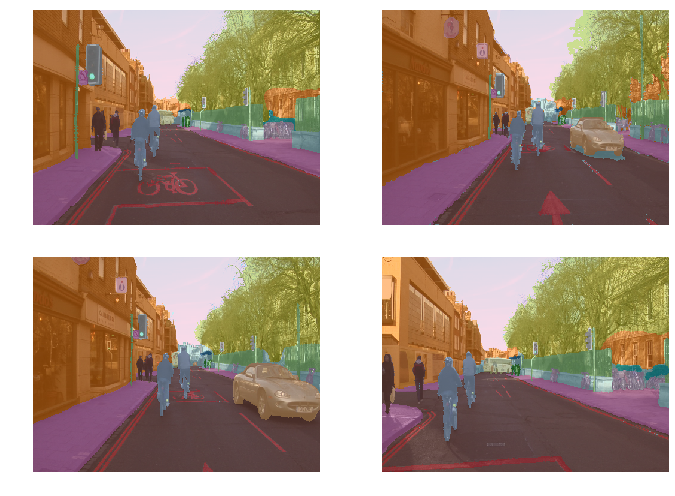

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [17]:
x = data.train_dl.one_batch()

## Model

In [18]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


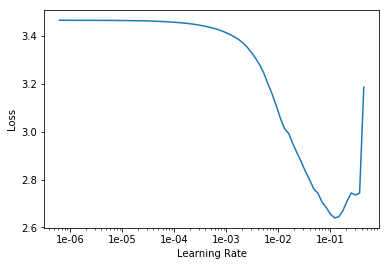

In [ ]:
lr_find(learn)
learn.recorder.plot()

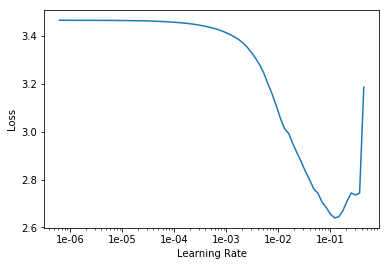

In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(3, slice(lr))

Total time: 00:46
epoch  train_loss  valid_loss  acc_camvid
1      2.457148    1.255123    0.759444    (00:16)
2      1.195904    0.701970    0.844283    (00:14)
3      0.859797    0.635383    0.852887    (00:14)



In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results()

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5,lr/5)

In [ ]:
learn.fit_one_cycle(12, lrs)

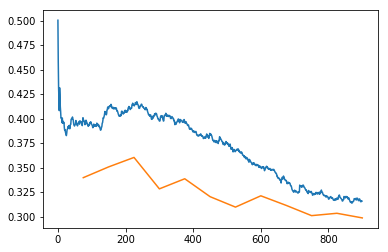

In [33]:
learn.recorder.plot_losses()

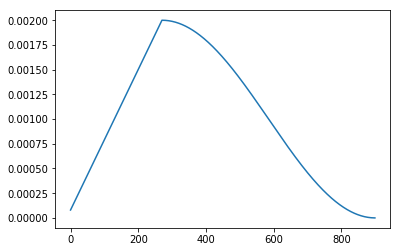

In [34]:
learn.recorder.plot_lr()

In [35]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [36]:
size = src_size
bs=4

In [37]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [38]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [39]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


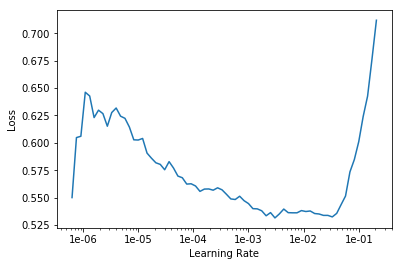

In [40]:
lr_find(learn)
learn.recorder.plot()

In [41]:
lr=1e-2

In [42]:
learn.fit_one_cycle(10, slice(lr))

Total time: 08:35
epoch  train_loss  valid_loss  acc_camvid
1      0.448386    0.357043    0.904134    (00:55)
2      0.448560    0.366886    0.900986    (00:51)
3      0.495479    0.363801    0.908867    (00:50)
4      0.465925    0.416285    0.884859    (00:50)
5      0.428596    0.367503    0.894545    (00:51)
6      0.395251    0.360665    0.894914    (00:51)
7      0.337518    0.309811    0.918450    (00:51)
8      0.311745    0.291748    0.920053    (00:51)
9      0.290585    0.289322    0.922161    (00:51)
10     0.275654    0.288043    0.921157    (00:50)



In [43]:
learn.save('stage-1-big')

In [44]:
learn.load('stage-1-big');

In [45]:
learn.unfreeze()

In [46]:
lrs = slice(1e-6,lr)

In [47]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 09:30
epoch  train_loss  valid_loss  acc_camvid
1      0.296419    0.353037    0.901543    (00:56)
2      0.324398    0.331924    0.911020    (00:57)
3      0.360990    0.365928    0.904883    (00:56)
4      0.370408    0.377845    0.899094    (00:56)
5      0.349200    0.343347    0.908758    (00:57)
6      0.313816    0.311648    0.918635    (00:57)
7      0.275192    0.261276    0.927446    (00:57)
8      0.252511    0.286806    0.925693    (00:57)
9      0.235742    0.258825    0.930306    (00:56)
10     0.227489    0.264015    0.929499    (00:56)



In [48]:
learn.save('stage-2-big')

In [49]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;
Train: LabelList
y: SegmentationLabelList (600 items)
[PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/Seq05VD_f03780_P.png')
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/Seq05VD_f02430_P.png')
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/Seq05VD_f01740_P.png')
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/0016E5_05340_P.png') ...
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/0016E5_01590_P.png')
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/Seq05VD_f00570_P.png')
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/0016E5_04980_P.png')
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/0016E5_08610_P.png')]
Path: .
x: SegmentationItemList (600 items)
[PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/images/Seq05VD_f03780.png')
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/images/Seq05VD_f02430.png')


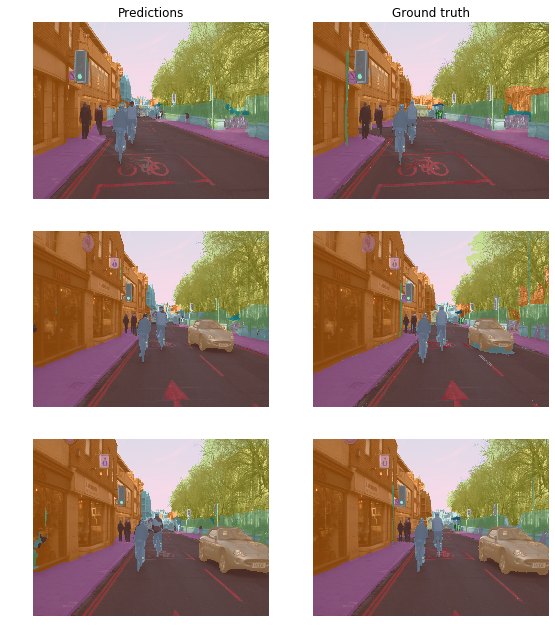

In [50]:
learn.show_results()